###**IMPORTS**

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras.datasets import cifar10

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score

import joblib
import time

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)


###**LOADING CIFAR10 DATASET**

In [40]:
# Load CIFAR-10 dataset
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

###**DATA PREPROCESSING**
**For Shallow Algorithms**

- **Binary Classification**:  
  Converted 10-class CIFAR-10 labels into binary:
  - `0` → Vehicle (airplane, automobile, ship, truck)
  - `1` → Animal (bird, cat, deer, dog, frog, horse)

- **Image Flattening**:  
  Reshaped each image from `(32, 32, 3)` to a 1D vector of length `3072`.

- **Normalization**:  
  Scaled pixel values from `[0, 255]` to `[0, 1]` by dividing by 255.

- **Standardization**:  
  Applied z-score normalization:
  - Mean = 0  
  - Standard Deviation = 1

- **Dimensionality Reduction (PCA)**:  
  Reduced features from `3072` to `100` components to reduce complexity and improve performance.


In [79]:
# Class names in CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Define binary classification: 'animal' (1) and 'vehicle' (0)
an_classes = [2, 3, 4, 5, 6, 7]       # animal classes: bird, cat, deer, dog, frog, horse
vehicle_classes = [0, 1, 8, 9]        # vehicle classes: airplane, automobile, ship, truck

# Convert multi-class labels to binary: 0 = vehicle, 1 = animal
# np.isin(...) returns a boolean mask for vehicle classes
# np.where(...) maps: True → 0 (vehicle), False → 1 (animal)
# .flatten() reshapes the result into a 1D array
y_train = np.where(np.isin(y_train_full, vehicle_classes), 0, 1).flatten()
y_test = np.where(np.isin(y_test_full, vehicle_classes), 0, 1).flatten()

# Flatten 32x32x3 images into 1D vectors of size 3072 (32*32*3)
# Normalize pixel values from [0, 255] to [0, 1] for better ML performance
X_train_flat = X_train_full.reshape(X_train_full.shape[0], -1) / 255.0
X_test_flat = X_test_full.reshape(X_test_full.shape[0], -1) / 255.0

# Standardize features: zero mean and unit variance
# Helps gradient-based models converge faster
# Also ensures distance-based models (like KNN) treat all features equally
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

print(f"X_train shape: {X_train_scaled.shape}")
print(f"y_train shape: {y_train.shape}")

from sklearn.decomposition import PCA

# Dimensionality reduction using PCA
# Reduce feature size from 3072 to 100 to improve model performance and reduce overfitting
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')

X_train shape: (50000, 3072)
y_train shape: (50000,)


['pca.pkl']

In [83]:
print(np.bincount(y_train))  # Check how many 0s and 1s


[20000 30000]


###**NON-PARAMETRIC ML ALGORITHM - K NEAREST NEIGHBOURS (KNN)**

Using K-Nearest Neighbors (KNN) for the CIFAR-10 image dataset presents both strengths and limitations. KNN is a simple, instance-based learning algorithm that works well for small datasets and low-dimensional data. However, CIFAR-10 images are high-dimensional (3072 features per image), which makes KNN computationally expensive and sensitive to the "curse of dimensionality." To address this, we applied dimensionality reduction using PCA, which significantly improves efficiency and classification performance. While KNN can capture patterns in the data without training a model in the traditional sense, it lacks the representational power of neural networks and doesn't scale well to large datasets. Nevertheless, when optimized carefully (e.g., through hyperparameter tuning, train-test split evaluation, and cross-validation), KNN can still offer competitive baseline results for binary classification tasks like distinguishing vehicles vs. animals in CIFAR-10.

## _MODEL 01: KNN (Manual Hyperparameter Tuning)_
- Conducted grid search on hyperparameters:
  - `n_neighbors`: 3 and 7
  - `weights`: 'uniform' and 'distance'
  - `metric`: 'euclidean' and 'manhattan'
- Selected the model with the highest accuracy on the test set.


In [42]:
%%time
# ------------------------------
# Step 1: Manual Hyperparameter Tuning
# ------------------------------
best_h_acc = 0
best_h_model = None
best_h_params = None

for n in [3,17]:
    for weight in ['uniform', 'distance']:
        for metric in ['euclidean', 'manhattan']:
            model = KNeighborsClassifier(n_neighbors=n, weights=weight, metric=metric)
            model.fit(X_train_pca, y_train)
            preds = model.predict(X_test_pca)
            acc = accuracy_score(y_test, preds)
            print(f"Params: n={n}, w={weight}, m={metric} => acc={acc:.4f}")
            if acc > best_h_acc:
                best_h_acc = acc
                best_h_model = model
                best_h_params = {
                    'n_neighbors': n,
                    'weights': weight,
                    'metric': metric
                }

print(f"\n✅ Best Manual Model: n={best_h_params['n_neighbors']}, w={best_h_params['weights']}, m={best_h_params['metric']} => acc={best_h_acc:.4f}")

Params: n=3, w=uniform, m=euclidean => acc=0.8282
Params: n=3, w=uniform, m=manhattan => acc=0.8194
Params: n=3, w=distance, m=euclidean => acc=0.8291
Params: n=3, w=distance, m=manhattan => acc=0.8204
Params: n=17, w=uniform, m=euclidean => acc=0.8163
Params: n=17, w=uniform, m=manhattan => acc=0.8085
Params: n=17, w=distance, m=euclidean => acc=0.8173
Params: n=17, w=distance, m=manhattan => acc=0.8092

✅ Best Manual Model: n=3, w=distance, m=euclidean => acc=0.8291
CPU times: user 4min 45s, sys: 440 ms, total: 4min 46s
Wall time: 4min 47s


## _MODEL 2: KNN (Train-Test Split Evaluation)_

- Re-evaluated the best hyperparameters from manual tuning.
- Tested on different train-test splits: 20%, 30%, and 40% test sizes.
- Selected the model with the best validation accuracy.


In [43]:
# ------------------------------
# Step 2: Train-Test Splits Evaluation
# ------------------------------

splits = [0.1, 0.3, 0.5]
best_split_acc = 0
best_split_model = None

for split in splits:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_train_pca, y_train, test_size=split, random_state=42)

    model = KNeighborsClassifier(**best_h_params)
    model.fit(X_train_split, y_train_split)
    acc = model.score(X_test_split, y_test_split)
    print(f"[Train-Test Split {split:.2f}] Accuracy: {acc:.4f}")

    if acc > best_split_acc:
        best_split_acc = acc
        best_split_model = model
        bestSpltRatio = split

params_str = ', '.join([f"{key}={value}" for key, value in best_h_params.items()])
print(f"[Train-Test Split] Best Accuracy: {best_split_acc:.4f} with {params_str}")

[Train-Test Split 0.10] Accuracy: 0.8206
[Train-Test Split 0.30] Accuracy: 0.8246
[Train-Test Split 0.50] Accuracy: 0.8143
[Train-Test Split] Best Accuracy: 0.8246 with n_neighbors=3, weights=distance, metric=euclidean


## _MODEL 3: KNN (K-Fold Cross-Validation)_

- Performed 5-fold cross-validation with the fixed best hyperparameters.
- Evaluated model performance across different splits.
- Selected model based on mean cross-validation accuracy.

In [44]:
# ------------------------------
# Step 3: K-Fold CV Evaluation
# ------------------------------
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_train_pca, y_train, test_size=bestSpltRatio, random_state=42)
print("\n--- 5-Fold Cross-Validation (Fixed Hyperparameters) ---")
final_model = KNeighborsClassifier(**best_h_params)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(final_model, X_train_split, y_train_split, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracies: {cv_scores}")

mean_acc = np.mean(cv_scores)
print(f"Mean CV Accuracy: {mean_acc:.4f}")

best_cv_acc = mean_acc
best_cv_model = final_model
print(f"[K-Fold CV] Best Mean Accuracy: {best_cv_acc:.4f} with {params_str}")


--- 5-Fold Cross-Validation (Fixed Hyperparameters) ---
Cross-Validation Accuracies: [0.82128571 0.80742857 0.81114286 0.817      0.81971429]
Mean CV Accuracy: 0.8153
[K-Fold CV] Best Mean Accuracy: 0.8153 with n_neighbors=3, weights=distance, metric=euclidean


## _FINAL KNN MODEL SELECTION_

In [45]:
# ------------------------------
# Step 4: Final Model Selection
# ------------------------------
best_model = None
best_model_source = ""
best_accuracy = max(best_h_acc, best_split_acc, best_cv_acc)

if best_accuracy == best_h_acc:
    best_model = best_h_model
    best_model_source = "Manual Hyperperameter Tuning"
elif best_accuracy == best_split_acc:
    best_model = best_split_model
    best_model_source = "Train-Test Split"
else:
    best_model = best_cv_model
    best_model_source = "K-Fold CV"

print(f"\n✅ Best Overall Model is from: {best_model_source} with Accuracy: {best_accuracy:.4f}")


✅ Best Overall Model is from: Manual Hyperperameter Tuning with Accuracy: 0.8291


## _SAVING FINAL KNN MODEL'S WEIGHTS FILE_

In [46]:
# ------------------------------
# Step 5: Save Best Model for Future Testing
# ------------------------------
joblib.dump(best_model, 'best_knn_model.pkl')
print("✅ Best model saved as 'best_knn_model.pkl'")

✅ Best model saved as 'best_knn_model.pkl'


##_EVALUATION OF KNN MODELS_

In [47]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    from sklearn.metrics import (
        classification_report, confusion_matrix, ConfusionMatrixDisplay,
        roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
    )
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Fit model (if not already fitted)
    try:
        model.predict(X_test)
    except:
        model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n🔍 Performance Report for: {name}")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Return results
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC": roc_auc
    }



🔍 Performance Report for: KNN - Hyper Parameters Tuning
              precision    recall  f1-score   support

           0     0.8453    0.7010    0.7664      4000
           1     0.8210    0.9145    0.8653      6000

    accuracy                         0.8291     10000
   macro avg     0.8332    0.8077    0.8158     10000
weighted avg     0.8308    0.8291    0.8257     10000



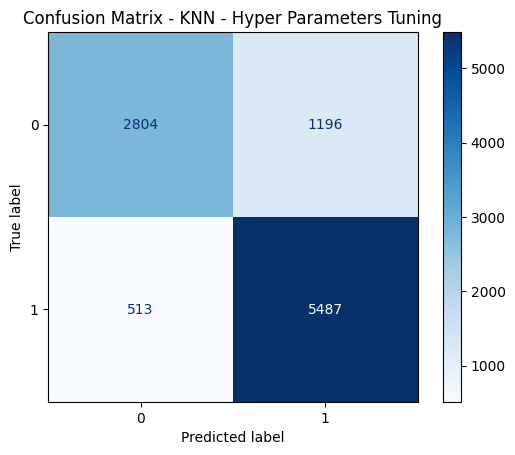

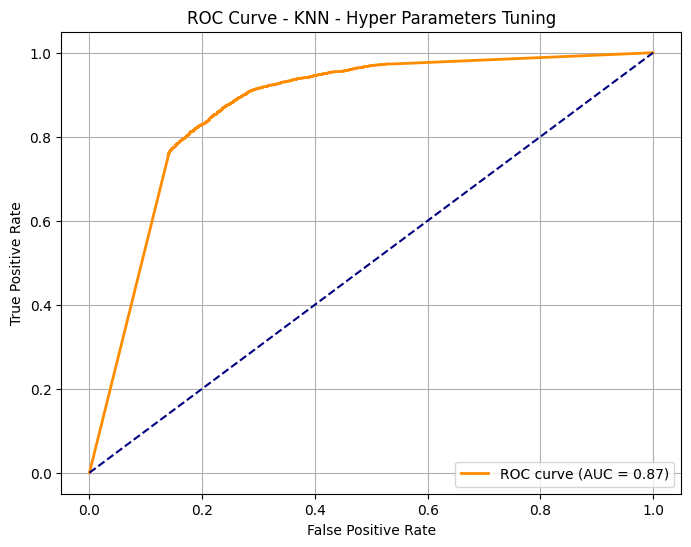


🔍 Performance Report for: KNN - Train-Test Split
              precision    recall  f1-score   support

           0     0.8320    0.6920    0.7556      4000
           1     0.8154    0.9068    0.8587      6000

    accuracy                         0.8209     10000
   macro avg     0.8237    0.7994    0.8071     10000
weighted avg     0.8220    0.8209    0.8174     10000



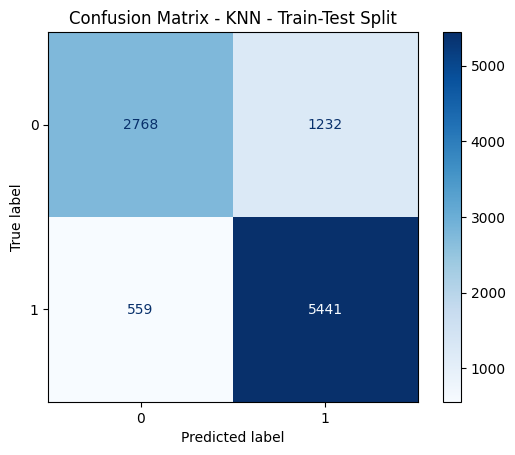

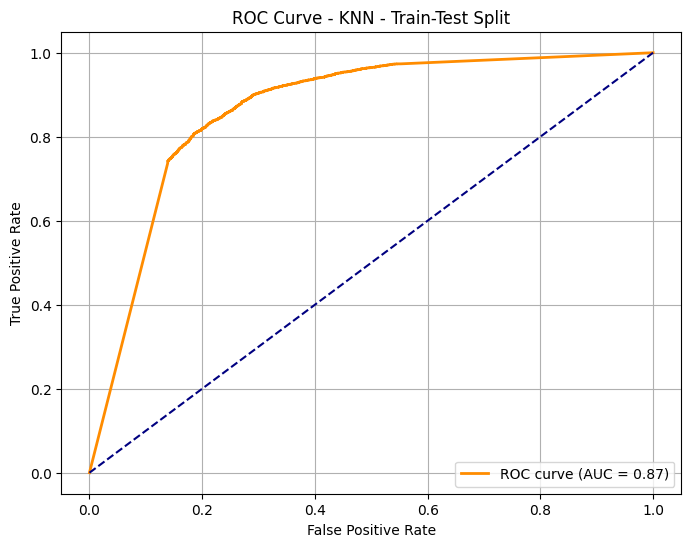


🔍 Performance Report for: KNN - K-Fold CV
              precision    recall  f1-score   support

           0     0.8453    0.7010    0.7664      4000
           1     0.8210    0.9145    0.8653      6000

    accuracy                         0.8291     10000
   macro avg     0.8332    0.8077    0.8158     10000
weighted avg     0.8308    0.8291    0.8257     10000



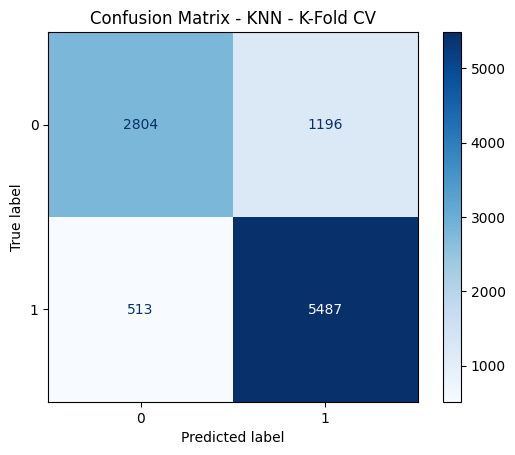

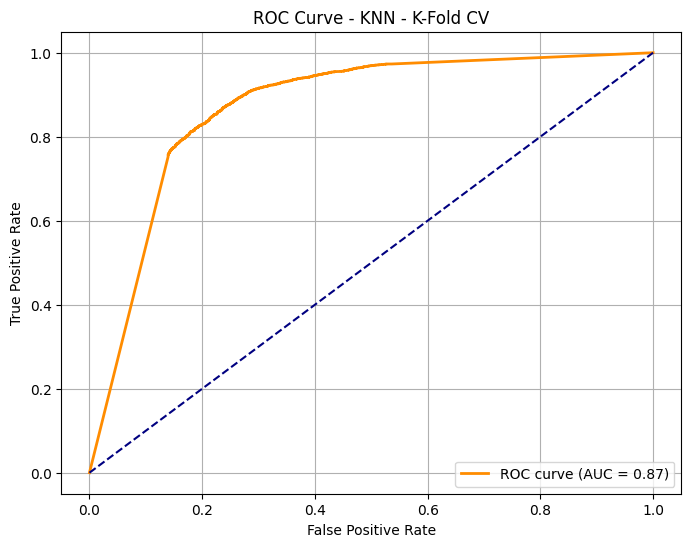

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,KNN - Hyper Parameters Tuning,0.8291,0.821038,0.914500,0.865253,0.870033
1,KNN - Train-Test Split,0.8209,0.815375,0.906833,0.858676,0.865247
2,KNN - K-Fold CV,0.8291,0.821038,0.914500,0.865253,0.870033


In [48]:
results_summary = []
results_summary.append(evaluate_model("KNN - Hyper Parameters Tuning", best_h_model, X_train_pca, X_test_pca, y_train, y_test))
results_summary.append(evaluate_model("KNN - Train-Test Split", best_split_model, X_train_pca, X_test_pca, y_train, y_test))
results_summary.append(evaluate_model("KNN - K-Fold CV", best_cv_model, X_train_pca, X_test_pca, y_train, y_test))

# Convert to DataFrame for tabular view
results_df = pd.DataFrame(results_summary)
results_df

#_GRAPHICAL RESULTS OF ALL KNN MODELS_

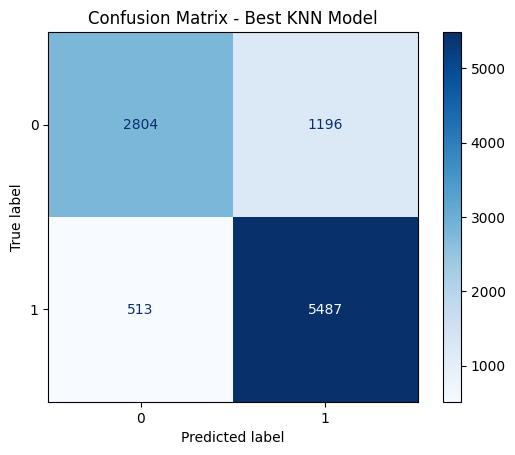

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test data using best_model
y_pred = best_model.predict(X_test_pca)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Best KNN Model")
plt.show()


In [50]:
# ------------------------------
# Step 3.5: Collect All Results for KNN
# ------------------------------

import pandas as pd

knn_results = [
    {
        "Algorithm": "KNN",
        "Approach": "Manual Hyperperameter Tuning",
        "Accuracy": best_h_acc,
        "Model": best_h_model,
        "Params": best_h_params
    },
    {
        "Algorithm": "KNN",
        "Approach": "Train-Test Split",
        "Accuracy": best_split_acc,
        "Model": best_split_model,
        "Params": best_h_params
    },
    {
        "Algorithm": "KNN",
        "Approach": "K-Fold CV",
        "Accuracy": best_cv_acc,
        "Model": best_cv_model,
        "Params": best_h_params
    }
]
# ------------------------------



###**PARAMETRIC ML ALGORITHM - LOGISTIC REGRESSION**

In [62]:


# ------------------------------from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# ------------------------------
# Step 1: Manual Hyperparameter Tuning (Valid Only)
# ------------------------------

# Define only valid combinations manually
valid_combinations = [
   {'C': 1.0, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 50},
   {'C': 0.8, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 100},
   {'C': 1.0, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 500}

]

best_h_lr_acc = 0
best_h_lr_model = None
best_h_lr_params = None

for params in valid_combinations:
    try:
        model = LogisticRegression(**params)
        model.fit(X_train_pca, y_train)
        preds = model.predict(X_test_pca)
        acc = accuracy_score(y_test, preds)
        print(f"Params: {params} => acc={acc:.4f}")

        if acc > best_h_lr_acc:
            best_h_lr_acc = acc
            best_h_lr_model = model
            best_h_lr_params = params

    except Exception as e:
        print(f"Skipping due to error: {e}")

# Final output
if best_h_lr_model:
    print(f"\n✅ Best Manual Logistic Regression Model:")
    print(f"   Params: {best_h_lr_params}")
    print(f"   Accuracy on Test Set: {best_h_lr_acc:.4f}")
else:
    print("❌ No valid model configuration found.")


# ------------------------------
# Step 2: Train-Test Split Evaluation
# ------------------------------
splits = [0.05, 0.3,0.4, 0.5]
best_lr_split_acc = 0
best_lr_split_model = None

for split in splits:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_train_pca, y_train, test_size=split, random_state=42
    )

    try:
        model = LogisticRegression(**best_h_lr_params)
        model.fit(X_train_split, y_train_split)
        acc = model.score(X_test_split, y_test_split)
        print(f"[Train-Test Split {split:.2f}] Accuracy: {acc:.4f}")

        if acc > best_lr_split_acc:
            best_lr_split_acc = acc
            best_lr_split_model = model
            bestSpltRatio = split
    except Exception as e:
        print(f"Failed for split={split}: {e}")

# ------------------------------
# Step 3: K-Fold CV Evaluation
# ------------------------------
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_train_pca, y_train, test_size=bestSpltRatio, random_state=42
    )

cv = KFold(n_splits=5, shuffle=True, random_state=42)

fold_scores = []
print(f"\n[Manual K-Fold CV] Using Best Hyperparameters: {best_h_lr_params}")

try:
    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_split)):
        X_train_fold = X_train_split[train_idx]
        y_train_fold = y_train_split[train_idx]
        X_val_fold = X_train_split[val_idx]
        y_val_fold = y_train_split[val_idx]

        model = LogisticRegression(**best_h_lr_params)
        model.fit(X_train_fold, y_train_fold)
        val_pred = model.predict(X_val_fold)
        acc = accuracy_score(y_val_fold, val_pred)
        fold_scores.append(acc)

        print(f"  Fold {fold_idx+1} Accuracy: {acc:.4f}")

    best_lr_cv_acc = np.mean(fold_scores)
    print(f"\n→ [Manual K-Fold CV] Mean Accuracy: {best_lr_cv_acc:.4f}")
    best_lr_cv_model = model.fit(X_train_pca, y_train)  # Retrain on full training data

except Exception as e:
    print(f"Error during manual K-Fold CV: {e}")

# ------------------------------
# Step 4: Final Model Selection
# ------------------------------
best_accuracy = max(best_h_lr_acc, best_lr_split_acc, best_lr_cv_acc)
best_model_source = ""
best_model = None

if best_accuracy == best_h_lr_acc:
    best_model = best_h_lr_model
    best_model_source = "Manual Hyperperameter Tuning"
elif best_accuracy == best_lr_split_acc:
    best_model = best_lr_split_model
    best_model_source = "Train-Test Split"
else:
    best_model = best_lr_cv_model
    best_model_source = "K-Fold CV"

print(f"\n✅ Best Overall Model is from: {best_model_source} with Accuracy: {best_accuracy:.4f}")

# ------------------------------
# Step 5: Save Best Model
# ------------------------------
joblib.dump(best_model, 'best_logistic_model.pkl')
print("✅ Best model saved as 'best_logistic_model.pkl'")


Params: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 50} => acc=0.8179
Params: {'C': 0.8, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 100} => acc=0.8179
Params: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 500} => acc=0.8179

✅ Best Manual Logistic Regression Model:
   Params: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 50}
   Accuracy on Test Set: 0.8179
[Train-Test Split 0.05] Accuracy: 0.8136
[Train-Test Split 0.30] Accuracy: 0.8195
[Train-Test Split 0.40] Accuracy: 0.8179
[Train-Test Split 0.50] Accuracy: 0.8178

[Manual K-Fold CV] Using Best Hyperparameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 50}
Error during manual K-Fold CV: index 35000 is out of bounds for axis 0 with size 35000

✅ Best Overall Model is from: Train-Test Split with Accuracy: 0.8195
✅ Best model saved as 'best_logistic_model.pkl'


In [52]:
# ------------------------------
# Step 3.5: Collect All Results for LR
# ------------------------------

import pandas as pd

lr_results = [
    {
        "Algorithm": "logistic_regression",
        "Approach": "Manual Hyperperameter Tuning",
        "Accuracy": best_h_lr_acc,
        "Model": best_h_lr_model,
        "Params": best_h_lr_params
    },
    {
        "Algorithm": "logistic_regression",
        "Approach": "Train-Test Split",
        "Accuracy": best_lr_split_acc,
        "Model": best_lr_split_model,
        "Params": best_h_lr_params
    },
    {
        "Algorithm": "logistic_regression",
        "Approach": "K-Fold CV",
        "Accuracy": best_lr_cv_acc,
        "Model": best_lr_cv_model,
        "Params": best_h_lr_params
    }
]

# ------------------------------




🔍 Performance Report for: LogReg - Hyperparameter Tuning
              precision    recall  f1-score   support

           0     0.7976    0.7320    0.7634      4000
           1     0.8306    0.8762    0.8528      6000

    accuracy                         0.8185     10000
   macro avg     0.8141    0.8041    0.8081     10000
weighted avg     0.8174    0.8185    0.8170     10000



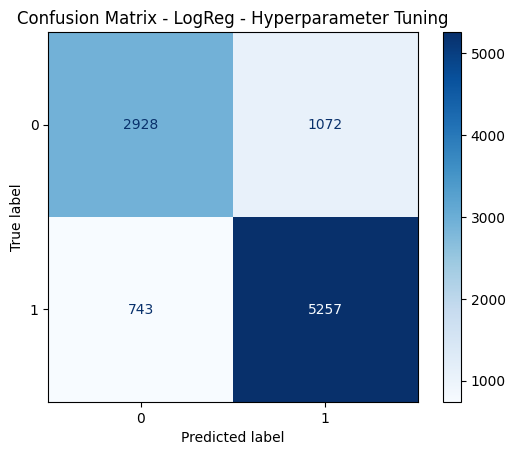

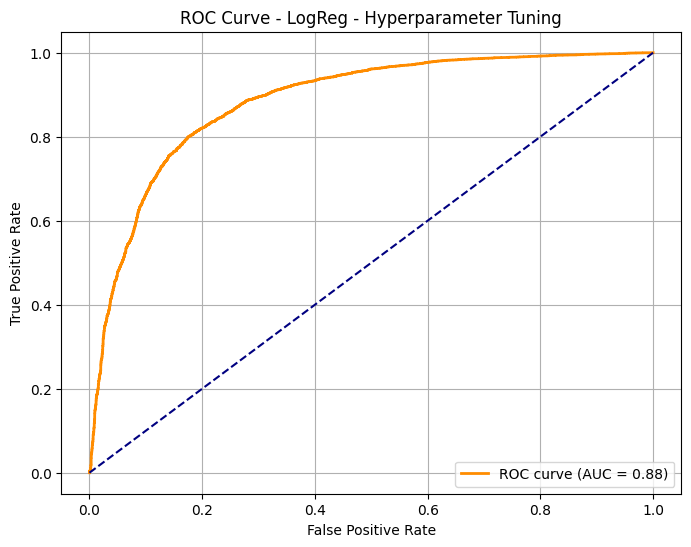


🔍 Performance Report for: LogReg - Train-Test Split
              precision    recall  f1-score   support

           0     0.7998    0.7292    0.7629      4000
           1     0.8295    0.8783    0.8532      6000

    accuracy                         0.8187     10000
   macro avg     0.8147    0.8038    0.8081     10000
weighted avg     0.8177    0.8187    0.8171     10000



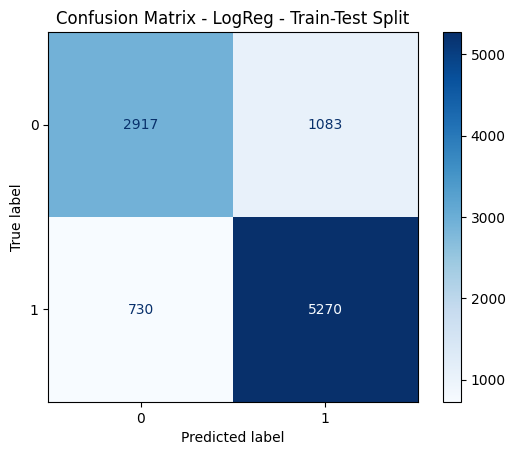

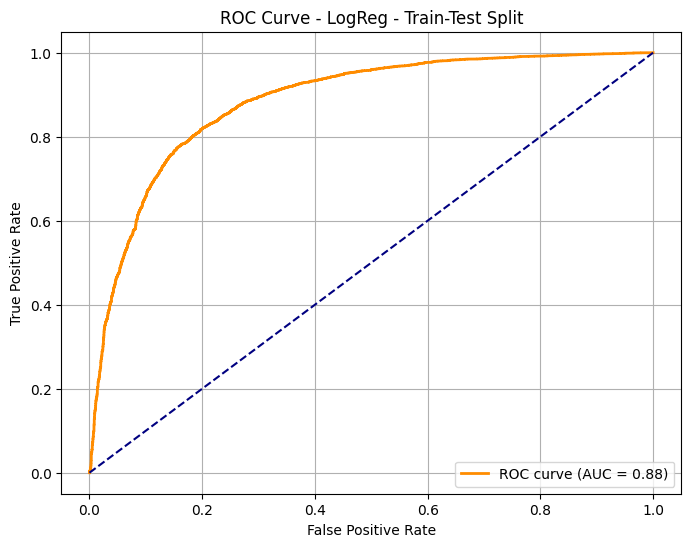


🔍 Performance Report for: LogReg - K-Fold CV
              precision    recall  f1-score   support

           0     0.7973    0.7328    0.7637      4000
           1     0.8310    0.8758    0.8528      6000

    accuracy                         0.8186     10000
   macro avg     0.8141    0.8043    0.8082     10000
weighted avg     0.8175    0.8186    0.8172     10000



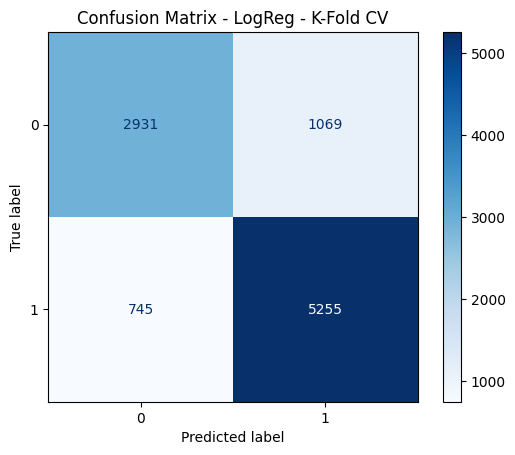

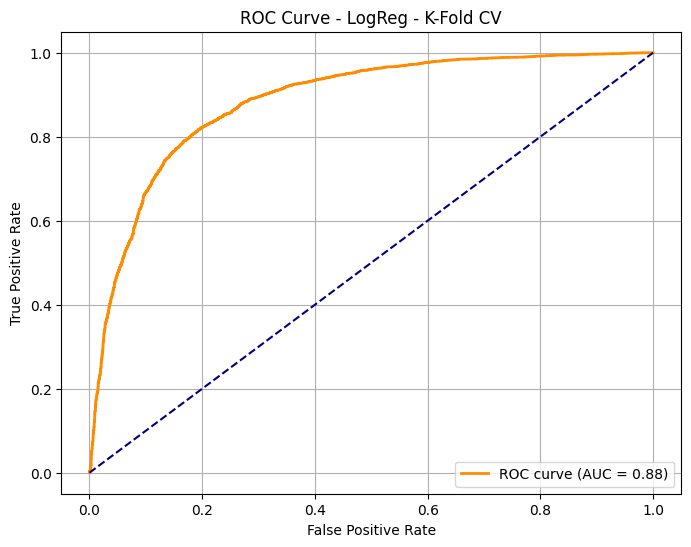

In [53]:
lr_results_summary = []
lr_results_summary.append(evaluate_model("LogReg - Hyperparameter Tuning", best_h_lr_model, X_train_pca, X_test_pca, y_train, y_test))
lr_results_summary.append(evaluate_model("LogReg - Train-Test Split", best_lr_split_model, X_train_pca, X_test_pca, y_train, y_test))
lr_results_summary.append(evaluate_model("LogReg - K-Fold CV", best_lr_cv_model, X_train_pca, X_test_pca, y_train, y_test))


In [54]:
lr_results_df = pd.DataFrame(lr_results_summary)
lr_results_df


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,LogReg - Hyperparameter Tuning,0.8185,0.830621,0.876167,0.852786,0.884204
1,LogReg - Train-Test Split,0.8187,0.829529,0.878333,0.853234,0.883582
2,LogReg - K-Fold CV,0.8186,0.830961,0.875833,0.852808,0.884285


In [55]:
all_results_df = pd.concat([results_df, lr_results_df], ignore_index=True)
all_results_df


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,KNN - Hyper Parameters Tuning,0.8291,0.821038,0.914500,0.865253,0.870033
1,KNN - Train-Test Split,0.8209,0.815375,0.906833,0.858676,0.865247
2,KNN - K-Fold CV,0.8291,0.821038,0.914500,0.865253,0.870033
3,LogReg - Hyperparameter Tuning,0.8185,0.830621,0.876167,0.852786,0.884204
4,LogReg - Train-Test Split,0.8187,0.829529,0.878333,0.853234,0.883582
5,LogReg - K-Fold CV,0.8186,0.830961,0.875833,0.852808,0.884285



📊 Accuracy Comparison Table:
             Algorithm                      Approach  Accuracy
0                  KNN  Manual Hyperperameter Tuning  0.829100
1                  KNN              Train-Test Split  0.824600
2                  KNN                     K-Fold CV  0.815314
3  logistic_regression  Manual Hyperperameter Tuning  0.818500
4  logistic_regression              Train-Test Split  0.820467
5  logistic_regression                     K-Fold CV  0.818020


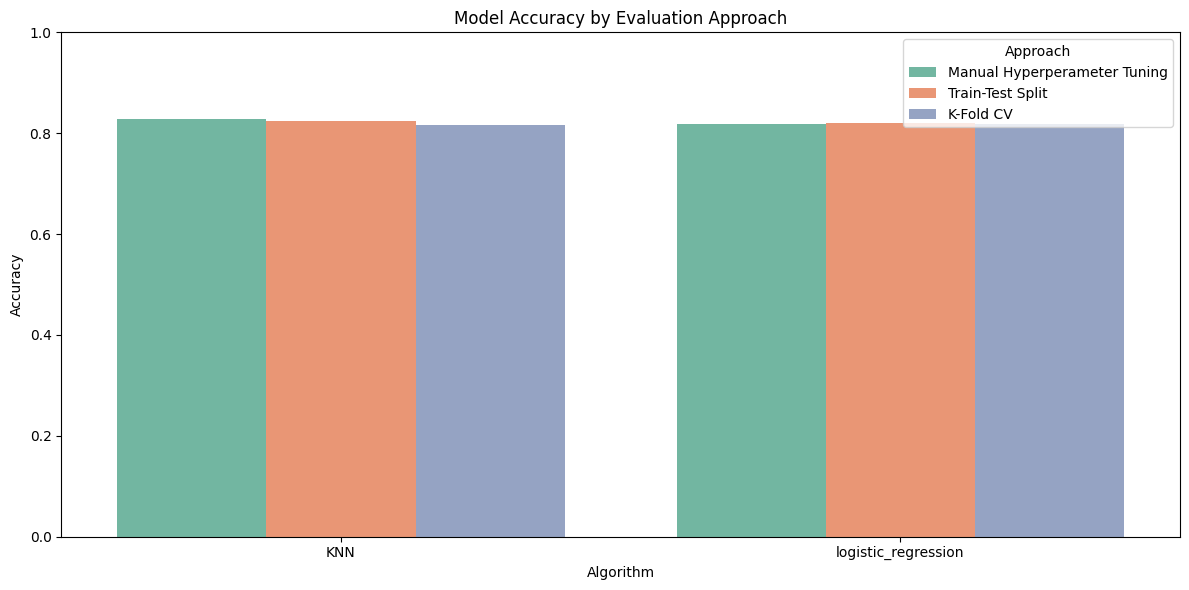

In [56]:
all_results = knn_results + lr_results
all_df = pd.DataFrame([{
    "Algorithm": r["Algorithm"],
    "Approach": r["Approach"],
    "Accuracy": r["Accuracy"]
} for r in all_results])

# Print table
print("\n📊 Accuracy Comparison Table:")
print(all_df)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=all_df, x="Algorithm", y="Accuracy", hue="Approach", palette="Set2")
plt.title("Model Accuracy by Evaluation Approach")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend(title="Approach")
plt.tight_layout()
plt.show()



###**Pca on  - LOGISTIC REGRESSION and KNN**


🔍 Performance Report for: KNN (PCA=5)
              precision    recall  f1-score   support

           0     0.6882    0.6538    0.6705      4000
           1     0.7766    0.8025    0.7893      6000

    accuracy                         0.7430     10000
   macro avg     0.7324    0.7281    0.7299     10000
weighted avg     0.7412    0.7430    0.7418     10000



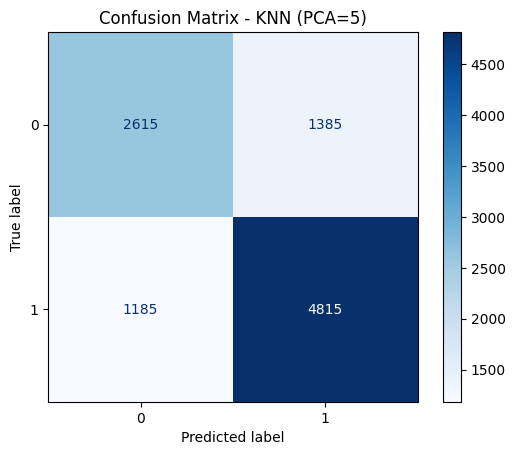

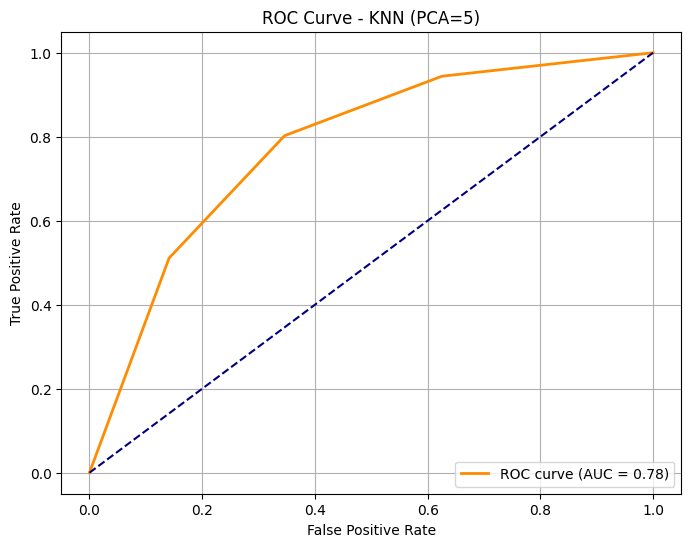


🔍 Performance Report for: LR (PCA=5)
              precision    recall  f1-score   support

           0     0.7653    0.6603    0.7089      4000
           1     0.7925    0.8650    0.8272      6000

    accuracy                         0.7831     10000
   macro avg     0.7789    0.7626    0.7680     10000
weighted avg     0.7816    0.7831    0.7799     10000



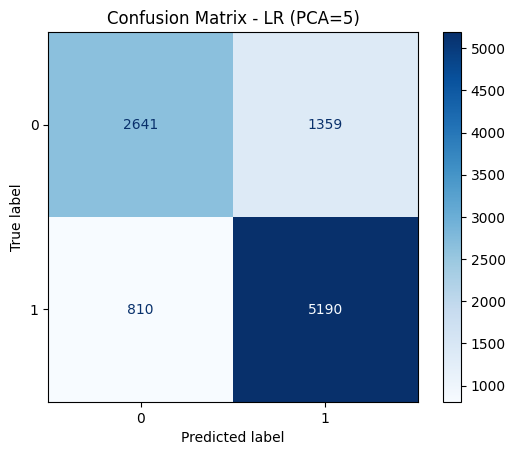

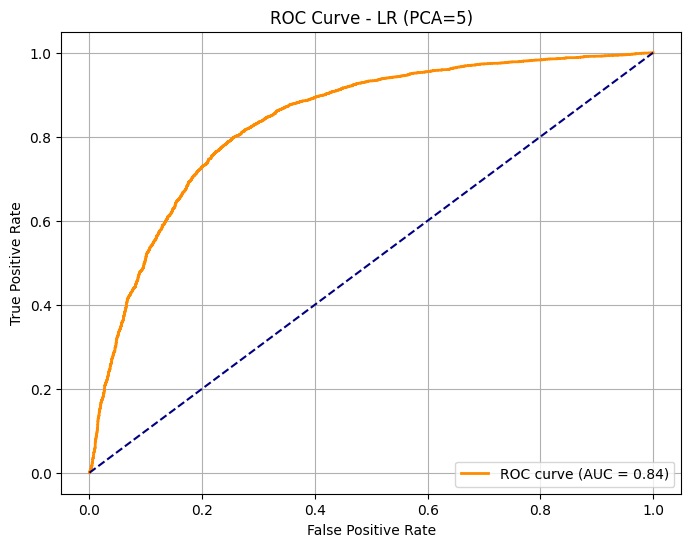


🔍 Performance Report for: KNN (PCA=64)
              precision    recall  f1-score   support

           0     0.8496    0.7120    0.7748      4000
           1     0.8267    0.9160    0.8691      6000

    accuracy                         0.8344     10000
   macro avg     0.8382    0.8140    0.8219     10000
weighted avg     0.8359    0.8344    0.8313     10000



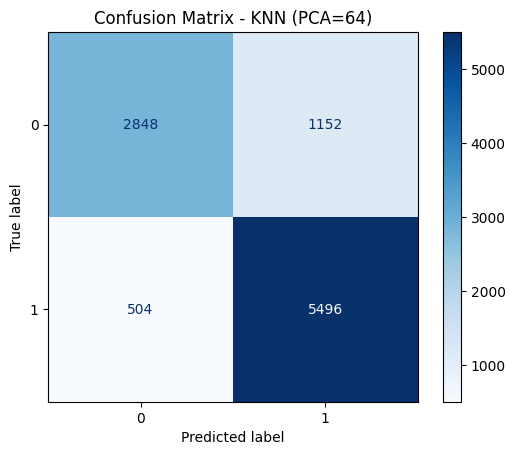

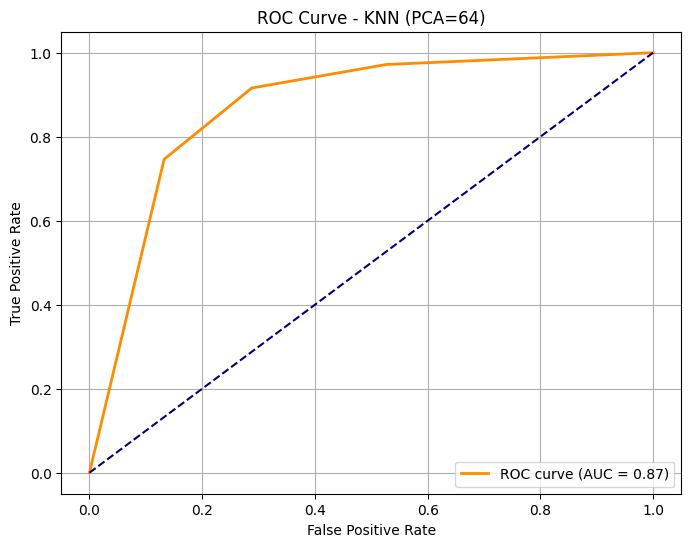


🔍 Performance Report for: LR (PCA=64)
              precision    recall  f1-score   support

           0     0.7973    0.7305    0.7624      4000
           1     0.8298    0.8762    0.8524      6000

    accuracy                         0.8179     10000
   macro avg     0.8136    0.8033    0.8074     10000
weighted avg     0.8168    0.8179    0.8164     10000



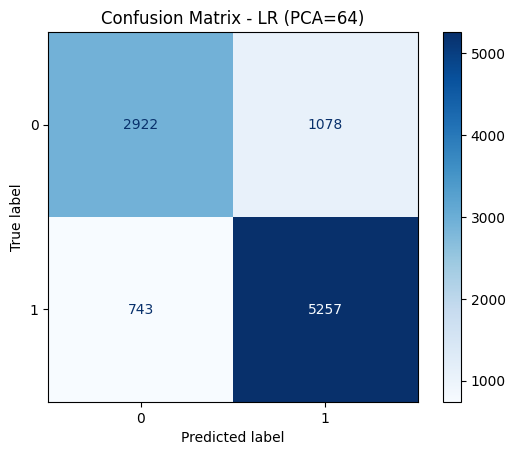

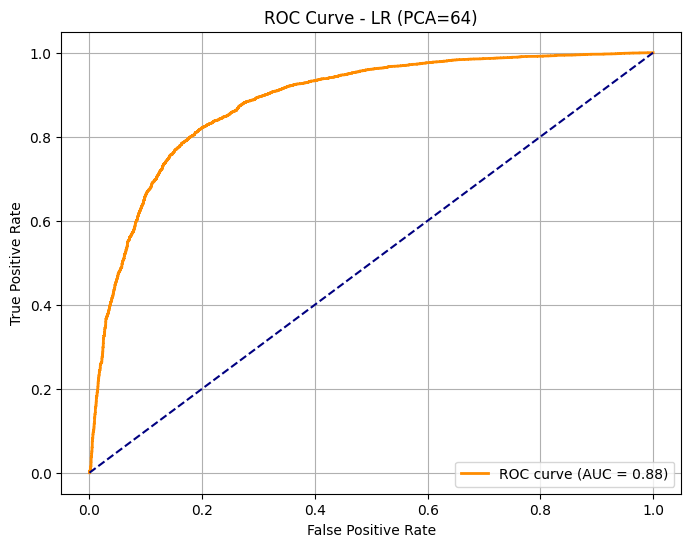


🔍 Performance Report for: KNN (PCA=0.9)
              precision    recall  f1-score   support

           0     0.8439    0.6990    0.7647      4000
           1     0.8199    0.9138    0.8643      6000

    accuracy                         0.8279     10000
   macro avg     0.8319    0.8064    0.8145     10000
weighted avg     0.8295    0.8279    0.8245     10000



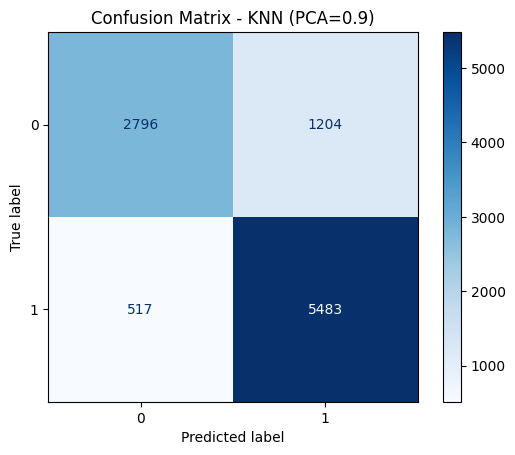

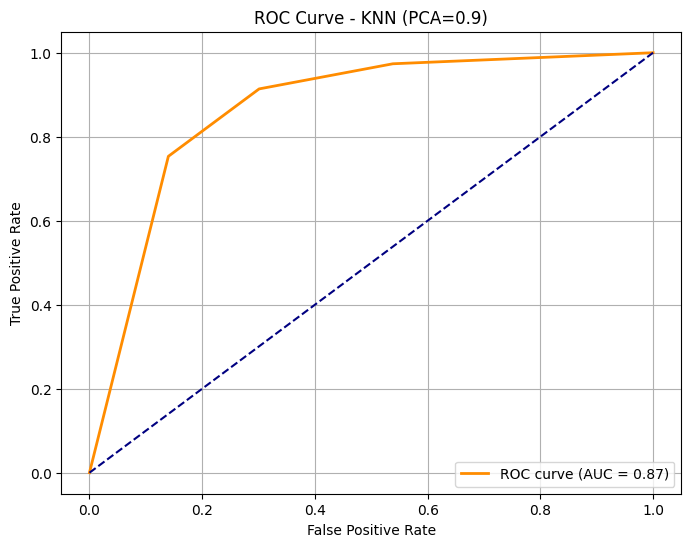


🔍 Performance Report for: LR (PCA=0.9)
              precision    recall  f1-score   support

           0     0.7969    0.7310    0.7626      4000
           1     0.8300    0.8758    0.8523      6000

    accuracy                         0.8179     10000
   macro avg     0.8135    0.8034    0.8074     10000
weighted avg     0.8168    0.8179    0.8164     10000



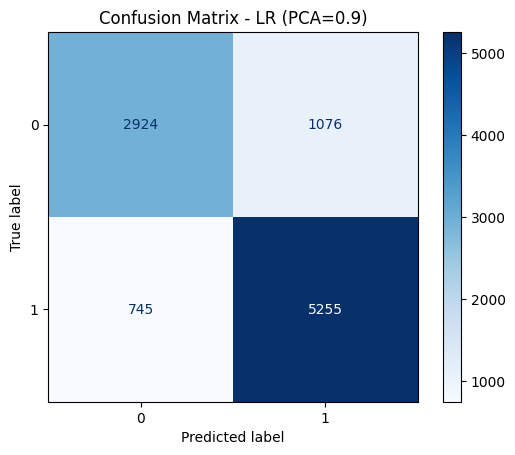

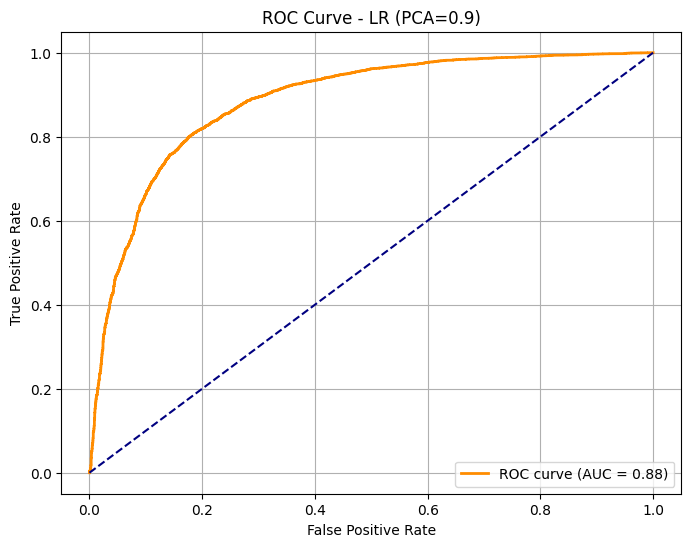

In [61]:
from sklearn.decomposition import PCA

pca_dims = [5, 64, 0.9]  # or up to X.shape[1] if not digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

results = []

for n_components in pca_dims:
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # ---- KNN ----
    knn = KNeighborsClassifier(n_neighbors=3)
    knn_result = evaluate_model(f"KNN (PCA={n_components})", knn, X_train_pca, X_test_pca, y_train, y_test)
    knn_result["Model Type"] = "KNN"
    knn_result["PCA Components"] = n_components
    results.append(knn_result)

    # ---- Logistic Regression ----
    lr = LogisticRegression(max_iter=1000)
    lr_result = evaluate_model(f"LR (PCA={n_components})", lr, X_train_pca, X_test_pca, y_train, y_test)
    lr_result["Model Type"] = "Logistic Regression"
    lr_result["PCA Components"] = n_components
    results.append(lr_result)


,Model Type,PCA Components,Accuracy,Precision,Recall,F1 Score,AUC
4,KNN,0.9,0.8279,0.819949,0.913833,0.864349,0.866515
0,KNN,5.0,0.7430,0.776613,0.802500,0.789344,0.778617
2,KNN,64.0,0.8344,0.826715,0.916000,0.869070,0.870668
5,Logistic Regression,0.9,0.8179,0.830043,0.875833,0.852323,0.884232
1,Logistic Regression,5.0,0.7831,0.792487,0.865000,0.827158,0.836927
3,Logistic Regression,64.0,0.8179,0.829834,0.876167,0.852371,0.883355


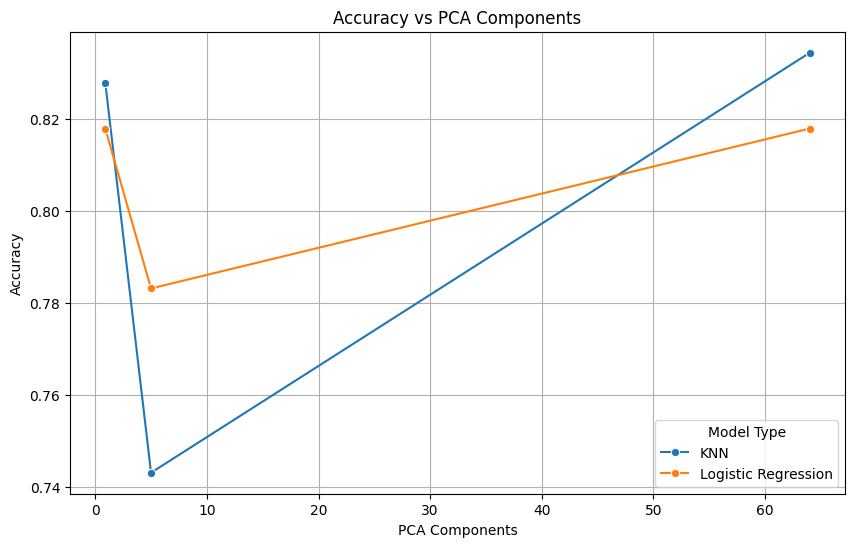

In [63]:

import pandas as pd

results_df = pd.DataFrame(results)
results_df = results_df[["Model Type", "PCA Components", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"]]
results_df.sort_values(by=["Model Type", "PCA Components"], inplace=True)
from IPython.display import display
display(results_df)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x="PCA Components", y="Accuracy", hue="Model Type", marker="o")
plt.title("Accuracy vs PCA Components")
plt.grid()
plt.show()




###**Transfer Learning - LOGISTIC REGRESSION**

In [68]:
from sklearn.linear_model import LogisticRegression

# Step 1: Train a Logistic Regression model on your scaled original features
pretrained_model = LogisticRegression(max_iter=100)
pretrained_model.fit(X_train_pca, y_train)

# Step 2: Use the decision function or predict_proba as new feature representation
X_train_transformed = pretrained_model.decision_function(X_train_pca)
X_test_transformed = pretrained_model.decision_function(X_test_pca)
# Reshape the transformed features
X_train_transformed = X_train_transformed.reshape(-1, 1)
X_test_transformed = X_test_transformed.reshape(-1, 1)

# Step 3: Train a new model on the transformed features
new_model = LogisticRegression(max_iter=100)
new_model.fit(X_train_transformed, y_train)

# Step 4: Evaluate
predictions = new_model.predict(X_test_transformed)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 81.79%


In [72]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import io
import joblib


In [ ]:
def preprocess_image(img):
    """Fixed version with proper standardization"""
    try:
        img = img.resize((32, 32))
         # Convert PIL image to numpy array and flatten
        img = np.array(img).reshape(1, -1) / 255.0
# Load fitted scaler and PCA
        scaler = joblib.load('scaler.pkl')
        pca = joblib.load('pca.pkl')

        # Transform using pre-fitted scaler and PCA
        img_scaled = scaler.transform(img)
        img_pca = pca.transform(img_scaled)
        
        return img_pca
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

# def predict_ann(img):
#     img_pca = preprocess_image(img)
#     if img_pca is None:
#         return "Error"

#     proba = model3.predict(img_pca, verbose=0)[0][0]
#     # print(f"Debug - Raw probability: {proba:.4f}")  # Check prediction values

#     # Adjust threshold if needed
    # return 1 if proba > 0.5 else 0
def predict_knn(img):
    img_pca = preprocess_image(img)
    # Load pre-trained models once
    knn_model = joblib.load('best_knn_model.pkl')

    if img_pca is None:
        return "Error"
    prediction = knn_model.predict(img_pca)[0]
    return prediction

def predict_lr(img):
    img_pca = preprocess_image(img)
    lr_model = joblib.load('best_logistic_model.pkl')
    print("img_pca shape:", img_pca.shape)


    try:
        prediction = lr_model.predict(img_pca)[0]
    except Exception as e:
        print(f"Prediction error: {e}")
        return "Error"
    if X_train_pca.shape[1] == img_pca.shape[1]:
        print("Same features")
    else:
        print("Different features")
    print("Probabilities:", lr_model.predict_proba(img_pca))
    print("img_pca shape:", img_pca.shape)
    print("Model expects:", lr_model.coef_.shape[1])

    return prediction

# Title
title = widgets.HTML(value="<h2 style='color:#2c3e50;'>Image Classification App</h2>")

# Upload widget (will be reset after prediction)
upload = widgets.FileUpload(accept='image/*', multiple=False)
upload.layout.margin = '10px 0px 10px 0px'

# Model selector
model_selector = widgets.Dropdown(
    options=['KNN', 'Log Regr'],
    description='Select Model:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='60%')
)

# Predict button
predict_button = widgets.Button(description='Predict', button_style='success', layout=widgets.Layout(width='40%'))

# Result label
result_label = widgets.HTML(value="", layout=widgets.Layout(margin='10px 0px 10px 0px'))

# Output area
output = widgets.Output()

# Prediction function
def on_predict_clicked(b):
    global upload
    with output:
        clear_output()
        if upload.value:
            img_data = list(upload.value.values())[0]
            pil_img = Image.open(io.BytesIO(img_data['content'])).convert('RGB')

            # Show uploaded image
            plt.figure(figsize=(3, 3))
            plt.imshow(pil_img)
            plt.axis('off')
            plt.title("Uploaded Image")
            plt.show()

            # Predict
            selected_model = model_selector.value
            # if selected_model == 'ANN':
            #     prediction = predict_ann(pil_img)
            if selected_model == 'KNN':
                prediction = predict_knn(pil_img)
            elif selected_model == 'Log Regr':
                prediction = predict_lr(pil_img)

            label_text = "Prediction: <b style='color:green;'>Vehicle</b>" if prediction == 0 else "Prediction: <b style='color:blue;'>Animal</b>"
            result_label.value = label_text

            # Reset upload
            upload.close()
            upload = widgets.FileUpload(accept='image/*', multiple=False)
            upload.layout.margin = '10px 0px 10px 0px'
            input_widgets.children = (upload, model_selector, predict_button)

        else:
            result_label.value = "<span style='color:red;'>⚠ Please upload an image.</span>"

# Attach event
predict_button.on_click(on_predict_clicked)

# Layout grouping
input_widgets = widgets.VBox([upload, model_selector, predict_button])
card = widgets.VBox([
    title,
    input_widgets,
    result_label,
    output
], layout=widgets.Layout(
    padding='20px',
    border='2px solid #dcdcdc',
    border_radius='10px',
    background_color='#f9f9f9',
    width='50%'
))

display(card)